<a href="https://colab.research.google.com/github/AgniKoko/Fetal_ECG_Separation/blob/ilias/Fetal_ECG_Separation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fetal ECG Seperation**
## A project for the class of **Electronic Measurements** (DUTH ECE: 8th Semester 2024-2025)

## - Κοκοροτσίκου Αγνή Ιωάννα / Kokorotsikou Agni Ioanna (58767)
## - Ξανθόπουλος Ηλίας / Xanthopoulos Ilias (58545)

## **Part 0**: Set-Up

1) Mount Google drive and load dataset.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import os
# import zipfile

# data_dir = '/content/drive/MyDrive/Fetal_ECG_Separation'
# database_zip = os.path.join(data_dir, 'database-1.0.0.zip')

# with zipfile.ZipFile(database_zip, 'r') as zip_ref:
#     zip_ref.extractall('/content')

# print("Dataset extracted successfully.")

In [3]:
data_dir = '/content/drive/MyDrive/ColabNotebooks/Fetal_ECG_Separation'
database_zip = os.path.join(data_dir, 'database-1.0.0.zip')

# train_dir = '/content/train/'
# os.makedirs(train_dir, exist_ok=True)

with zipfile.ZipFile(database_zip, 'r') as zip_ref:
    zip_ref.extractall('/content')

print("Dataset extracted successfully.")

Dataset extracted successfully.


2) Install and import libraries.

In [4]:
!pip install wfdb
!pip install pyedflib

In [5]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.fftpack import fft, fftfreq
from sklearn.decomposition import FastICA
import pyedflib
import seaborn as sns

import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import butter, filtfilt, spectrogram, stft, find_peaks
from scipy.fft import rfft, rfftfreq, irfft
from sklearn.decomposition import FastICA
import os
import zipfile
import pyedflib

## **Part 1**: Signal Extraction

1) Read .edf file of choice, extract saved signals and print useful data information. Seperate ground truth signal ('Direct_1') from the abdomen signals and save QRS types and timestamps of ground truth.

In [34]:
# Input EDF file name
# ----------------------
rec = 'r01'
# ----------------------

file_path = f'/content/abdominal-and-direct-fetal-ecg-database-1.0.0/{rec}.edf'
edf_file = pyedflib.EdfReader(file_path)

signal_num = edf_file.signals_in_file
signal_labels = edf_file.getSignalLabels()
fs = edf_file.getSampleFrequency(0)  # Fs: Sampling Frequency

signals_list = [edf_file.readSignal(i) for i in range(signal_num)]
signals = np.array(signals_list)

print(f"There are {signal_num} signals/channels in edf file.")
print("Signal Labels:", signal_labels)
print(f"Sampling frequency fs: {fs}Hz")
print("(Num of channels, Num of samples over time) = ", signals.shape)

edf_file._close()

ground_truth = signals[0,:]
abdomen_signals = signals[1:,:]

qrs_annotations = wfdb.rdann(file_path, "qrs")

qrs_peaks = np.array(qrs_annotations.sample)
qrs_symbols = np.array(qrs_annotations.symbol)

rr_intervals = np.diff(qrs_peaks)
print("RR Intervals (samples):", rr_intervals[:10])

There are 5 signals/channels in edf file.
Signal Labels: ['Direct_1', 'Abdomen_1', 'Abdomen_2', 'Abdomen_3', 'Abdomen_4']
Sampling frequency fs: 1000.0Hz
(Num of channels, Num of samples over time) =  (5, 300000)
RR Intervals (samples): [468 467 465 466 465 468 469 469 469 468]


In [35]:
# # Ορισμός της διαδρομής προς το EDF αρχείο
# file_path = f'/content/abdominal-and-direct-fetal-ecg-database-1.0.0/{rec}.edf'

# # Άνοιγμα του EDF αρχείου
# f = pyedflib.EdfReader(file_path)

# # Εμφάνιση των ονομάτων των καναλιών
# n_signals = f.signals_in_file
# signal_labels = f.getSignalLabels()
# print("Signal Labels:", signal_labels)

# # Ανάγνωση όλων των καναλιών και αποθήκευση σε λίστα
# signals_list = [f.readSignal(i) for i in range(n_signals)]
# fs = f.getSampleFrequency(0)
# print("Sampling frequency (fs):", fs)

# f._close()  # Κλείσιμο του αρχείου

# # Μετατροπή της λίστας σε NumPy array και transpose για να έχουμε σχήμα (δείγματα x κανάλια)
# signals = np.array(signals_list).T
# print("Σχήμα signals:", signals.shape)

# n_samples = signals.shape[0]
# time = np.arange(n_samples) / fs
# n_channels = signals.shape[1]

# plt.figure(figsize=(12, 3 * n_channels))
# for i in range(n_channels):
#     plt.subplot(n_channels, 1, i + 1)
#     plt.plot(time, signals[:, i])
#     plt.title(f'Κανάλι {i+1}: {signal_labels[i]}')
#     plt.xlabel('Δείγματα')
#     plt.ylabel('Τιμή')

# plt.tight_layout()
# plt.show()


In [36]:
# # Εφαρμογή ICA με αριθμό συστατικών (π.χ. 3)
# n_components = 3

# ica = FastICA(n_components, whiten="unit-variance")
# # S = ica.fit_transform(signals[:,1:])
# S = (ica.fit_transform(abdomen_signals.T)).T
# W = ica.components_

# ica_components = S

# print("Demixing Matrix W:\n", W)
# print("Demixing Matrix W shape:\n", W.shape)

# time = np.arange(ica_components.shape[0]) / fs

# # plt.figure(figsize=(12, 10))
# # for i in range(ica_components.shape[1]):
# #     plt.subplot(ica_components.shape[1], 1, i + 1)
# #     plt.plot(time, ica_components[:, i])
# #     plt.title(f'ICA: Component {i+1}')
# #     plt.xlabel('Χρόνος (sec)')
# #     plt.ylabel('Τιμή')
# # plt.tight_layout()
# # plt.show()

# print(signals.shape)
# print("ica_components.shape:", ica_components.shape)

In [37]:
rr_intervals_sec = rr_intervals / fs
print("RR Intervals (seconds):", rr_intervals_sec[:10])
min_rr = np.min(rr_intervals_sec)
print("Minimum RR Interval (seconds):", min_rr)

RR Intervals (seconds): [0.468 0.467 0.465 0.466 0.465 0.468 0.469 0.469 0.469 0.468]
Minimum RR Interval (seconds): 0.4


In [38]:
instantaneous_hr_hz = 1 / rr_intervals_sec
instantaneous_hr_bpm = instantaneous_hr_hz * 60
print("Instantaneous Heart Rates (Hz):", instantaneous_hr_hz[:10])
print("Instantaneous Heart Rates (bpm):", instantaneous_hr_bpm[:10])
print(np.max(instantaneous_hr_hz))

Instantaneous Heart Rates (Hz): [2.13675214 2.14132762 2.15053763 2.14592275 2.15053763 2.13675214
 2.13219616 2.13219616 2.13219616 2.13675214]
Instantaneous Heart Rates (bpm): [128.20512821 128.47965739 129.03225806 128.75536481 129.03225806
 128.20512821 127.93176972 127.93176972 127.93176972 128.20512821]
2.5


2) Plot extracted signals over a specified amount of time. For the ground truth, plot the peaks of QRS complex according to saved timestamps as well.

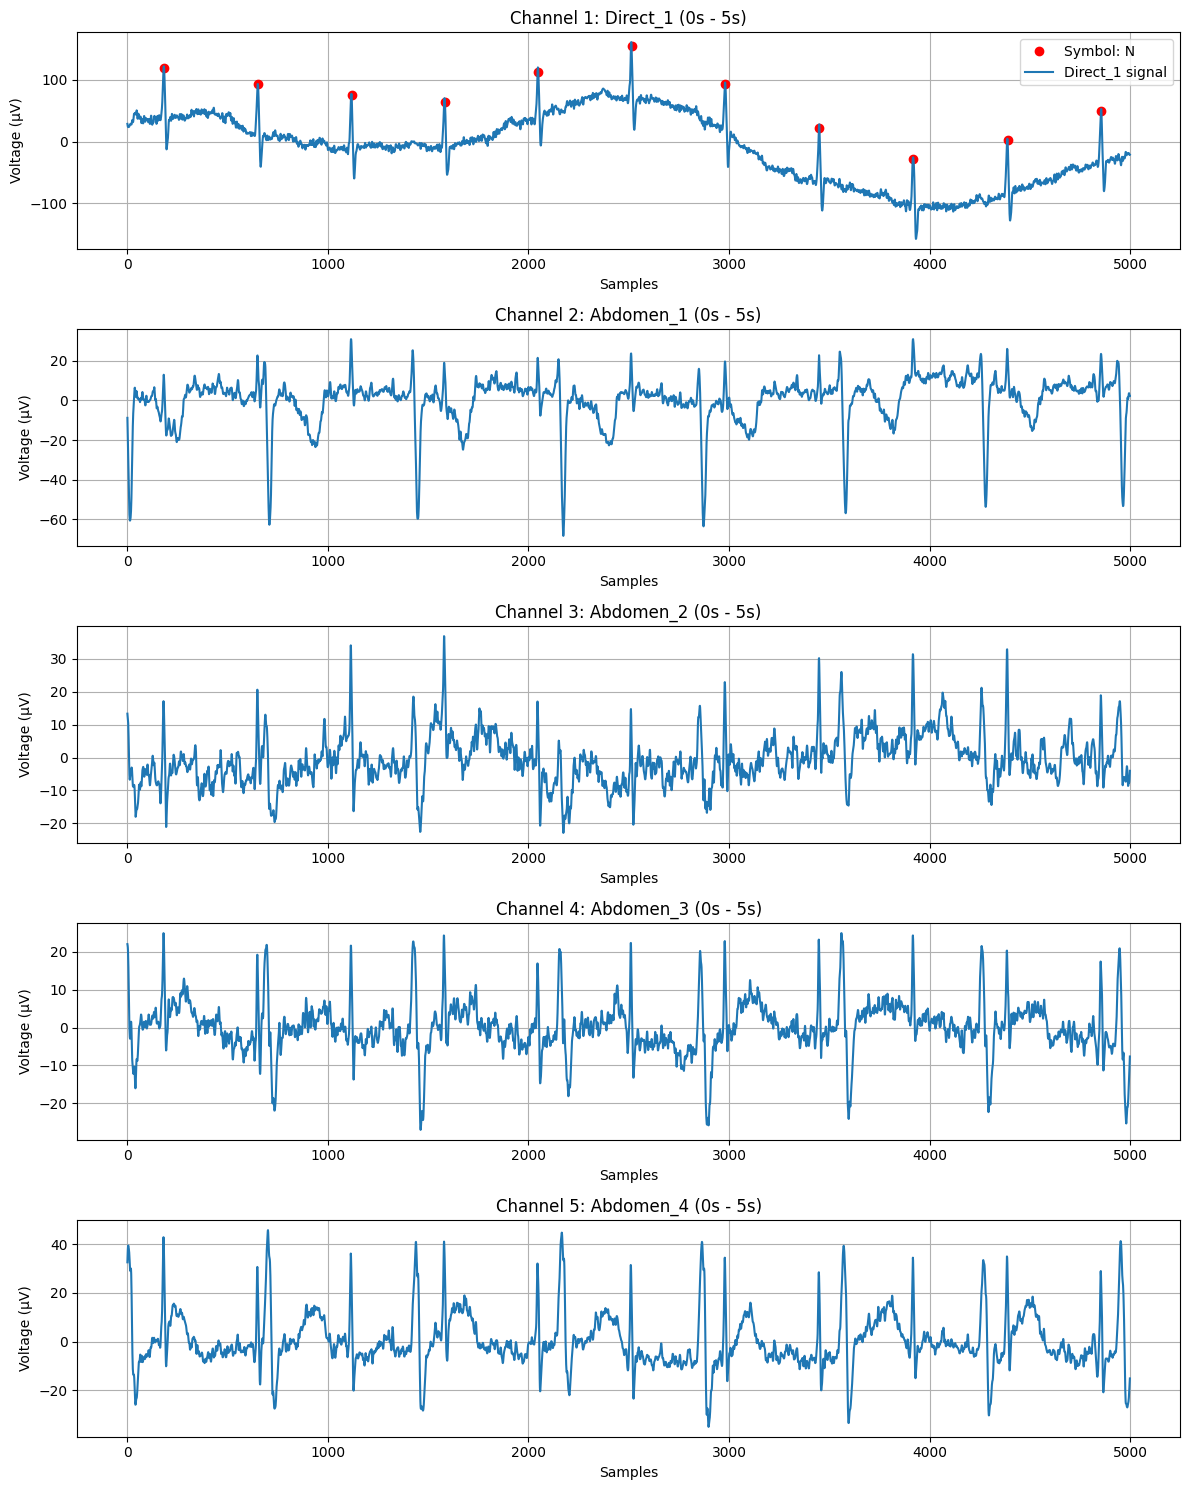

In [39]:
# Input start time and duration (in seconds) for signal plots.
# ----------------------
start_time = 0
duration = 5  # Each signal lasts 300sec.
# ----------------------

# ex. For duration = 3000 sec, 300 * fs = 300 * 1000 = 300000 samples.
start_samp = start_time * int(fs)
fin_samp = (start_time + duration) * int(fs)

symbol_colors = {
    'N': 'r',  # Normal beat - red
    'V': 'g',  # Ventricular - green
    'A': 'yellow',  # Atrial - yellow
    'L': 'orange',  # LBBB - orange
    'R': 'purple',  # RBBB - purple

    '': 'k'   # Unspecified - black
}

cropped_signals = signals[:, start_samp:fin_samp]
cropped_qrs = qrs_peaks[(qrs_peaks >= start_samp) & (qrs_peaks < fin_samp)]
cropped_sym = qrs_symbols[(qrs_peaks >= start_samp) & (qrs_peaks < fin_samp)]
channel_num = cropped_signals.shape[0]

plt.figure(figsize=(12, 3 * channel_num))

for symbol in np.unique(cropped_sym):
    color = symbol_colors.get(symbol, 'gray')  # default to gray if unknown
    sym_samples = cropped_qrs[cropped_sym == symbol] - start_samp
    plt.subplot(channel_num, 1, 1)
    plt.plot(sym_samples, cropped_signals[0,sym_samples], 'o', color=color, label=f'Symbol: {symbol}')

plt.plot(cropped_signals[0,:], label='Direct_1 signal')
plt.title(f'Channel {1}: {signal_labels[0]} ({start_time}s - {start_time + duration}s)')
plt.xlabel('Samples')
plt.ylabel('Voltage (μV)')
plt.legend()
plt.grid()

for i in range(1, channel_num):
    plt.subplot(channel_num, 1, i + 1)
    plt.plot(cropped_signals[i,:])
    plt.title(f'Channel {i+1}: {signal_labels[i]} ({start_time}s - {start_time + duration}s)')
    plt.xlabel('Samples')
    plt.ylabel('Voltage (μV)')
    plt.grid()

plt.tight_layout()
plt.show()

3) Calculate instantaneous Heart Rate over time. Interpolate to achieve a continuous graph and plot the results over a specified amount of time.

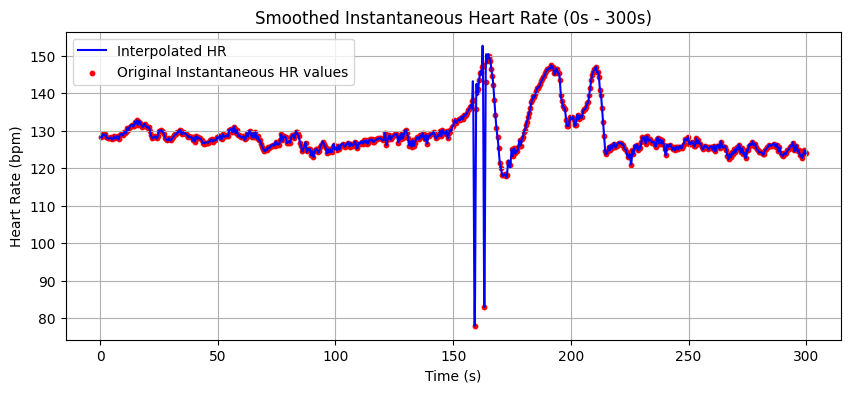

In [40]:
from scipy.interpolate import interp1d

# Input start time and duration (in seconds) for Heart Rate plot.
# Input the points/sec for interpolated Hear Rate.
# ----------------------
start_time = 0
duration = 300 # Signal lasts 300sec.

resolution = 50 # (50-100) recommended
# ----------------------

end_time = start_time + duration

rr_intervals_sec = np.diff(qrs_peaks) / fs
instantaneous_hr_hz = 1 / rr_intervals_sec
instantaneous_hr_bpm = instantaneous_hr_hz * 60

qrs_timestamps = qrs_peaks / fs
hr_timestamps = (qrs_timestamps[:-1] + qrs_timestamps[1:]) / 2

time_mask = (hr_timestamps >= start_time) & (hr_timestamps < end_time)
cropped_hr_times= hr_timestamps[time_mask]
cropped_hr_bpm = instantaneous_hr_bpm[time_mask]

time_span = cropped_hr_times[-1] - cropped_hr_times[0]
time_space = np.linspace(cropped_hr_times[0], cropped_hr_times[-1], num=int(time_span * resolution))

hr_func = interp1d(cropped_hr_times, cropped_hr_bpm, kind='cubic')
continuous_hr = hr_func(time_space)

plt.figure(figsize=(10, 4))
plt.plot(time_space, continuous_hr, color='b', label='Interpolated HR')
plt.scatter(cropped_hr_times, cropped_hr_bpm , color='r', s=10, label='Original Instantaneous HR values')
plt.title(f'Smoothed Instantaneous Heart Rate ({start_time}s - {end_time}s)')
plt.xlabel('Time (s)')
plt.ylabel('Heart Rate (bpm)')
plt.grid(True)
plt.legend()
plt.show()

## **Part 2**: Independent Component Analysis (ICA) Application

1) Check if data needs whitening. Print mean value of signals and covariance matrix. Plot a heatmap of covariance matrix for better visualization.

Data needs whitening if the mean value of each signal is non-zero (meaning that the signals need centering) and/or the covariance matrix is not equal to the identity matrix.

The mean value of each abdomen channel is: [[0.03170482 0.02849677 0.0525478  0.05981291]]
Signals need centering: True

Covariance Matrix:
[[438.77066468  21.57937935  -5.83546577 -52.74160762]
 [ 21.57937935 777.03895811 125.53325188  68.36066034]
 [ -5.83546577 125.53325188 255.55825214  74.51686671]
 [-52.74160762  68.36066034  74.51686671 383.93749103]]

Deviation from Identity (Frobenius norm): 1031.432268879835
Data needs whitening: True



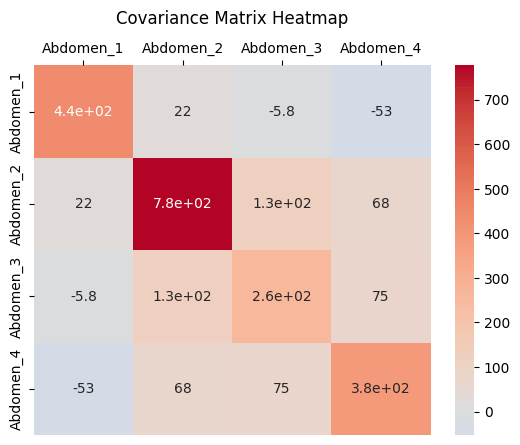

In [41]:
abd_signal_mean = np.mean(abdomen_signals, axis=1, keepdims=True)
center_flag = not np.allclose(abd_signal_mean, np.zeros((abdomen_signals.shape[0],1)),
                                 atol=1e-5)

# Mean array is transposed for clearer reading.
print(f"The mean value of each abdomen channel is:", abd_signal_mean.T)
print("Signals need centering:", center_flag)
print()

cov_mat = np.cov(abdomen_signals)
identity = np.eye(cov_mat.shape[0])
deviation_flag = not np.allclose(cov_mat, identity, atol=1e-5)
error = np.linalg.norm(cov_mat - identity)

print("Covariance Matrix:")
print(cov_mat)
print()

print("Deviation from Identity (Frobenius norm):", error)
print("Data needs whitening:", deviation_flag)
print()

cov_heat = sns.heatmap(cov_mat, annot=True, cmap='coolwarm',center=0,
            xticklabels=signal_labels[1:], yticklabels=signal_labels[1:])

cov_heat.xaxis.set_ticks_position('top')
cov_heat.xaxis.set_label_position('top')
cov_heat.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
plt.title("Covariance Matrix Heatmap", pad=30)
plt.show()

2) Perform ICA over the abdomen signals. Whitening is applied before ICA, if necessary.

In [54]:
if (deviation_flag or center_flag):
  ica = FastICA(n_components=2, # or 3 for noise
                whiten='arbitrary-variance', # or 'unit-variance' but arbitrary is preferred
                fun='logcosh', # or 'exp' because of spikes (doesn't seem better)
                fun_args={'alpha': 1}, # or >1.2 because is probs better for spikes (doesn't seem better)
                random_state=1,
                )
else:
  ica = FastICA(n_components=2,
                whiten=False,
                fun='logcosh',
                fun_args={'alpha': 1.0},
                random_state=1,
                )

S = (ica.fit_transform(abdomen_signals.T)).T
W = ica.components_

ica_components = S
time = np.arange(ica_components.shape[1]) / fs

print(signals.shape)
print("ica_components.shape:", ica_components.shape)

# # Two ICA applications compared

# ica1 = FastICA(n_components=2, # or 3 for noise
#                 whiten='arbitrary-variance',
#                 fun='logcosh', # or 'exp' because of spikes
#                 fun_args={'alpha': 1.0}, # or >1.2 because is probs better for spikes
#                 random_state=1,
#                 )

# S1 = (ica1.fit_transform(abdomen_signals.T)).T
# W1 = (ica1.components_).T

(5, 300000)
ica_components.shape: (2, 300000)


3) Print the demixing matrix W. Plot the sources/components S over time.

Demixing Matrix W:
 [[-6.87940225e-06 -6.12585537e-05 -1.41158214e-05 -8.55727993e-06]
 [ 7.01019390e-05  4.71616782e-06 -1.22544091e-05 -4.37872638e-05]]

Demixing Matrix W shape: (num of channels, num of sources) = (2, 4)



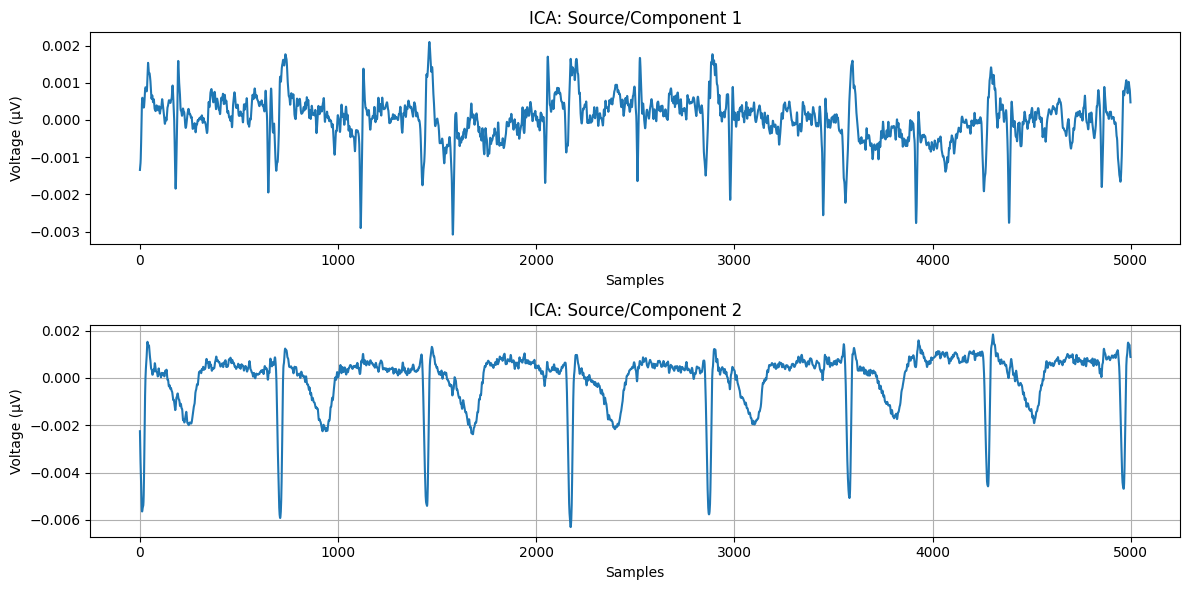

In [55]:
# Input start time and duration (in seconds) for signal plots.
# ----------------------
start_time = 0
duration = 5  # Each signal lasts 300sec.
# ----------------------

print("Demixing Matrix W:\n", W)
print()
print("Demixing Matrix W shape: (num of channels, num of sources) =", W.shape)
print()

# print("Demixing Matrix W1:\n", W1)
# print()
# print("Demixing Matrix W1 shape: (num of channels, num of sources) =", W1.shape)
# print()

# ex. For duration = 3000 sec, 300 * fs = 300 * 1000 = 300000 samples.
cropped_signals = S[:, start_time * int(fs):(start_time + duration) * int(fs)]
source_num = cropped_signals.shape[0]
plt.figure(figsize=(12, 3 * source_num))
for i in range(source_num):
    plt.subplot(source_num, 1, i + 1)
    plt.plot(cropped_signals[i,:])
    plt.title(f'ICA: Source/Component {i+1}')
    plt.xlabel('Samples')
    plt.ylabel('Voltage (μV)')

plt.tight_layout()
plt.grid()
plt.show()

# cropped_signals = S1[:, start_time * int(fs):(start_time + duration) * int(fs)]
# source_num = cropped_signals.shape[0]
# plt.figure(figsize=(12, 3 * source_num))
# for i in range(source_num):
#     plt.subplot(source_num, 1, i + 1)
#     plt.plot(cropped_signals[i,:])
#     plt.title(f'ICA: Component {i+1}')
#     plt.xlabel('Samples')
#     plt.ylabel('Voltage (μV)')

# plt.tight_layout()
# plt.grid()
# plt.show()

## **Part 3**: Maternal vs. Fetal ECG Identification

In this part the distiction between the Maternal and Fetal ECG is executed. The classification is achieved through the extraction of heart beat frequency of each Source. The one with higher frequency is matched to the Fetus and the lower to the Mother. To identify the Heart Rates, three different methods are utilized and compared:

1.   Fast Fourier Transform (FFT)
2.   Autocorrelation
3.   Wavelets






### **Part 3.1**: Fast Fourier Transform (FFT)

fetal_rr: [0.468 0.466 0.465 0.466 0.466 0.468 0.469 0.469 0.469 0.468]
maternal_rr: [0.629 0.931 0.734 0.666 0.938 0.782 0.625 0.635 0.77  0.934]
Component 0: Fetal or Noise | HR: 125.51 bpm | Dom Freq: 0.3766666666666667 Hz


<ipython-input-70-3bcf6311cf67>:32: RuntimeWarning: divide by zero encountered in divide
  density_fetal = len(fetal_peaks) / time
<ipython-input-70-3bcf6311cf67>:33: RuntimeWarning: divide by zero encountered in divide
  density_maternal = len(maternal_peaks) / time


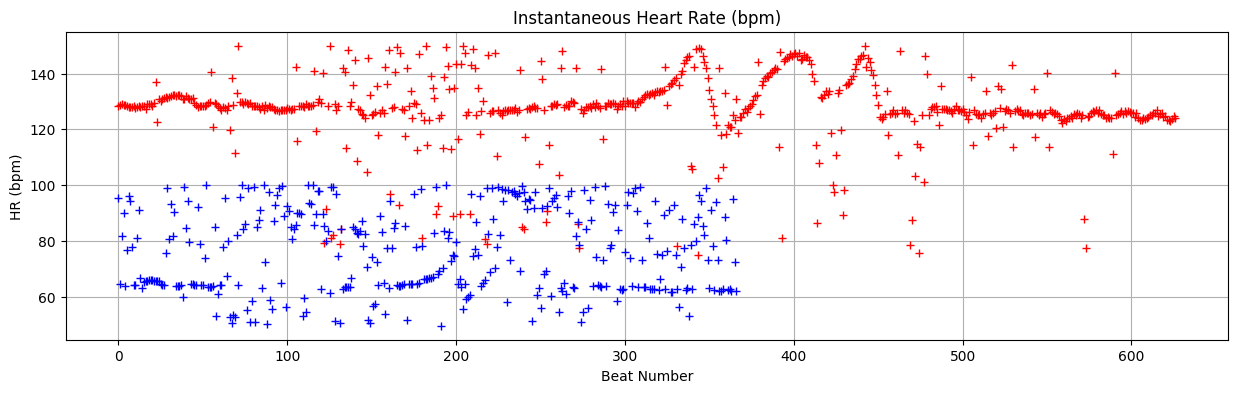

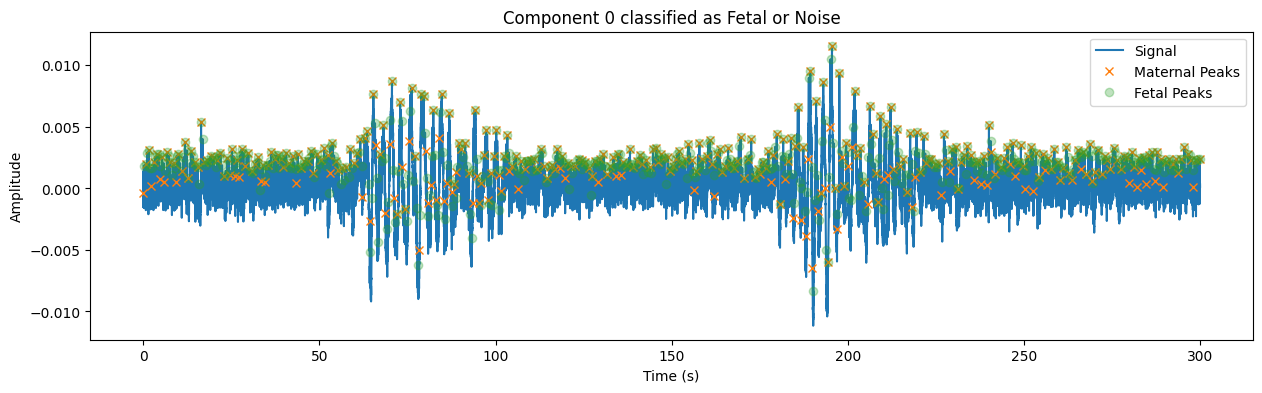

fetal_rr: [0.697 0.741 0.725 0.698 0.709 0.699 0.685 0.677 0.656 0.612]
maternal_rr: [0.697 0.741 0.725 0.698 0.709 0.699 0.685 0.677 0.656 0.612]
Component 1: Maternal | HR: 81.93 bpm | Dom Freq: 0.5066666666666667 Hz


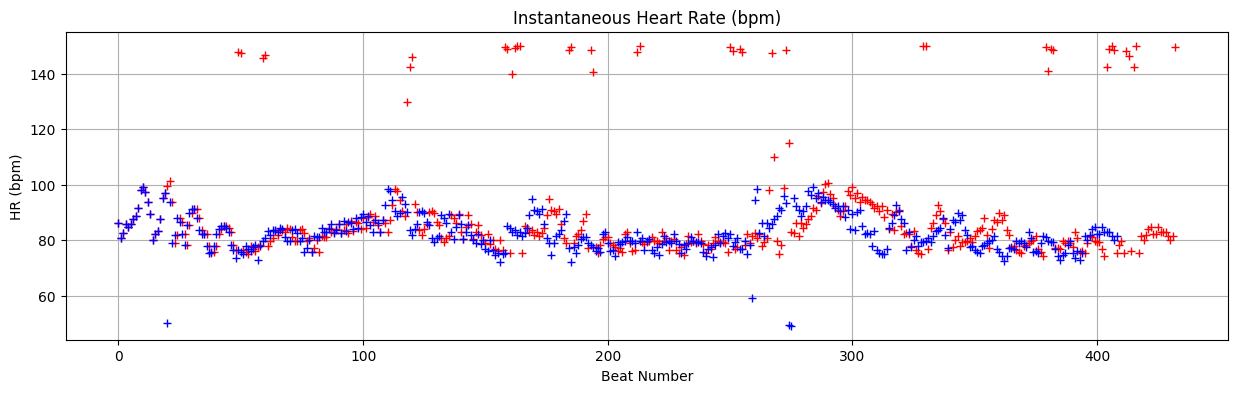

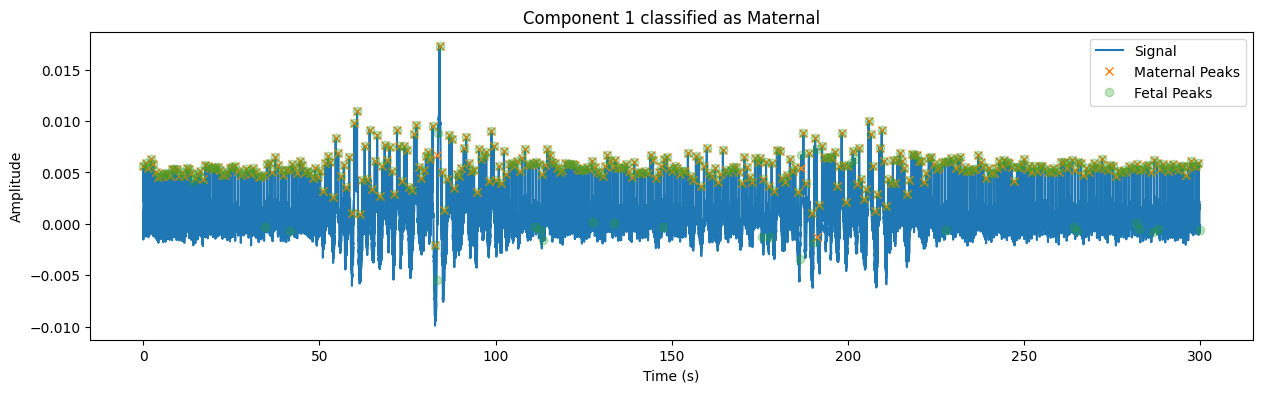

In [70]:
fetal_or_noise_signal = [1, ica_components.shape[0]]

for i in range(ica_components.shape[0]):
    duration_sec = 20 * fs
    signal = ica_components[i, :]

    # Flip if average peak in -signal is stronger
    if np.max(-signal) > np.max(signal):
        signal = -signal

    # Maternal peaks
    maternal_peaks, maternal_props = find_peaks(signal, distance=int(0.6*fs))

    if len(maternal_peaks) > 1:
        maternal_rr = np.diff(maternal_peaks) / fs
        hr_maternal = 60 / np.mean(maternal_rr)
    else:
        hr_maternal = np.nan

    # Fetal peaks
    fetal_peaks, fetal_props = find_peaks(signal, distance=int(min_rr*fs))

    if len(fetal_peaks) > 1:
        fetal_rr = np.diff(fetal_peaks) / fs # min_rr
        hr_fetal = 60 / np.mean(fetal_rr)
    else:
        hr_fetal = np.nan

    print(f"fetal_rr: {fetal_rr[:10]}")
    print(f"maternal_rr: {maternal_rr[:10]}")

    density_fetal = len(fetal_peaks) / time
    density_maternal = len(maternal_peaks) / time

    consistency_fetal = np.std(fetal_rr)
    consistency_maternal = np.std(maternal_rr)

    # Frequency domain analysis
    yf = np.abs(np.fft.rfft(signal))
    xf = np.fft.rfftfreq(signal.shape[0], 1 / fs)

    # Limit to cardiac-relevant band (0.5–5 Hz)
    mask = (xf > 0.1) & (xf < 5)
    dominant_freq = xf[mask][np.argmax(yf[mask])]

    fetal_ihr_hz = 1 / fetal_rr
    fetal_ihr_bpm = 60 / fetal_rr
    maternal_ihr_hz = 1 / maternal_rr
    maternal_ihr_bpm = 60 / maternal_rr

    if np.abs(np.mean(fetal_ihr_bpm) - np.mean(maternal_ihr_bpm)) > 10:
        label, hr = "Fetal or Noise", hr_fetal
        fetal_or_noise_signal.append(signal)
    else:
        label, hr = "Maternal", hr_maternal
    print(f"Component {i}: {label} | HR: {hr:.2f} bpm | Dom Freq: {dominant_freq} Hz")

    plt.figure(figsize=(15, 4))
    plt.plot(fetal_ihr_bpm, "r+", label="Fetal IHRs")
    plt.plot(maternal_ihr_bpm, "b+", label="Maternal IHRs")
    plt.title("Instantaneous Heart Rate (bpm)")
    plt.xlabel("Beat Number")
    plt.ylabel("HR (bpm)")
    plt.grid()
    plt.show()


    # Main plot:
    plt.figure(figsize=(15, 4))
    plt.plot(time[:], signal, label="Signal")
    plt.plot(time[maternal_peaks], signal[maternal_peaks], "x", label="Maternal Peaks")
    plt.plot(time[fetal_peaks], signal[fetal_peaks], "o", label="Fetal Peaks", alpha=0.3)
    plt.title(f"Component {i} classified as {label}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

### **Part 3.2**: Autocorrelation

### **Part 3.3**: Wavelets

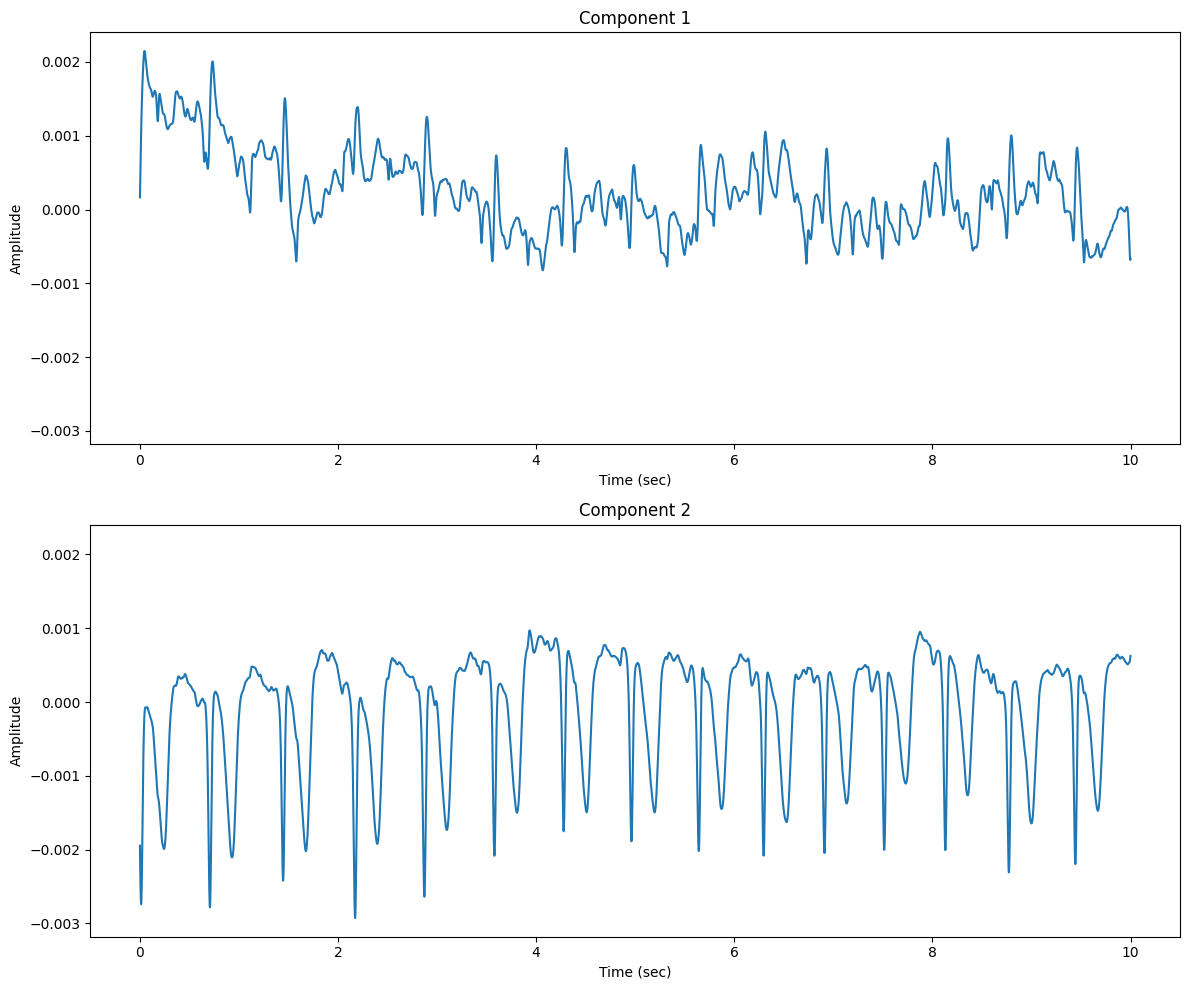

In [60]:
def bandpass_filter(data, lowcut, highcut, fs, order=1):
    nyq = 0.5 * fs  # συχνότητα Nyquists
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

filtered_signals = np.zeros_like(ica_components)

for i in range(ica_components.shape[0]):
    filtered_signals[i, :] = bandpass_filter(
        data=ica_components[i, :],
        lowcut= 0.1,
        highcut=10,
        fs=fs,
    )

fig, axes = plt.subplots(filtered_signals.shape[0], 1, sharey=True, figsize=(12, 10))
for i, ax in enumerate(axes):
    ax.plot(time[:10000], filtered_signals[i, :10000])
    ax.set_title(f'Component {i+1}')
    ax.set_xlabel('Time (sec)')
    ax.set_ylabel('Amplitude')
plt.tight_layout()
plt.show()

ica_components.shape: (2, 300000)
ica_components[0].shape (first row): (300000,)


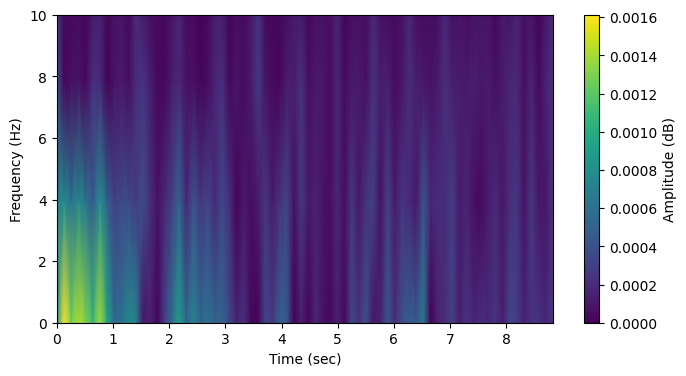

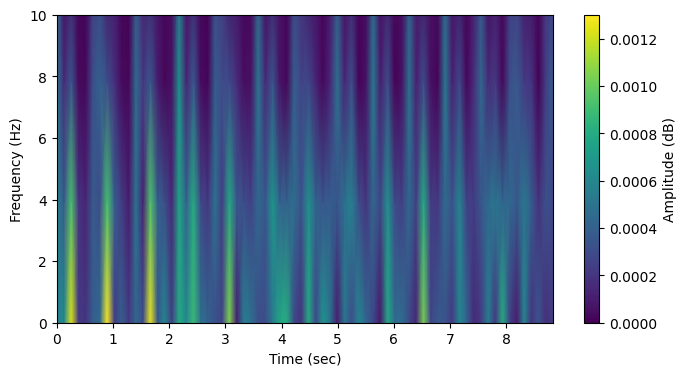

In [63]:
print("ica_components.shape:", ica_components.shape)
print("ica_components[0].shape (first row):", ica_components[1].shape)

time_limit = 70
for i in range(filtered_signals.shape[0]):
  # Compute the STFT on the selected component
  f, t, Zxx = stft(filtered_signals[i, :], fs=fs, nperseg=256)

  # print("Shape of f:", f.shape)
  # print("Shape of t:", t.shape)
  # print("Shape of Zxx:", Zxx.shape)

  # Plot the spectrogram
  plt.figure(figsize=(8, 4))
  plt.pcolormesh(t[:time_limit], f, np.abs(Zxx[:, :time_limit]), shading='gouraud')
  plt.ylabel("Frequency (Hz)")
  plt.xlabel("Time (sec)")
  plt.colorbar(label="Amplitude (dB)")
  plt.ylim([0, 10])
  plt.show()

In [64]:
!pip install PyWavelets
import pywt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 43.4 MB/s eta 0:00:00


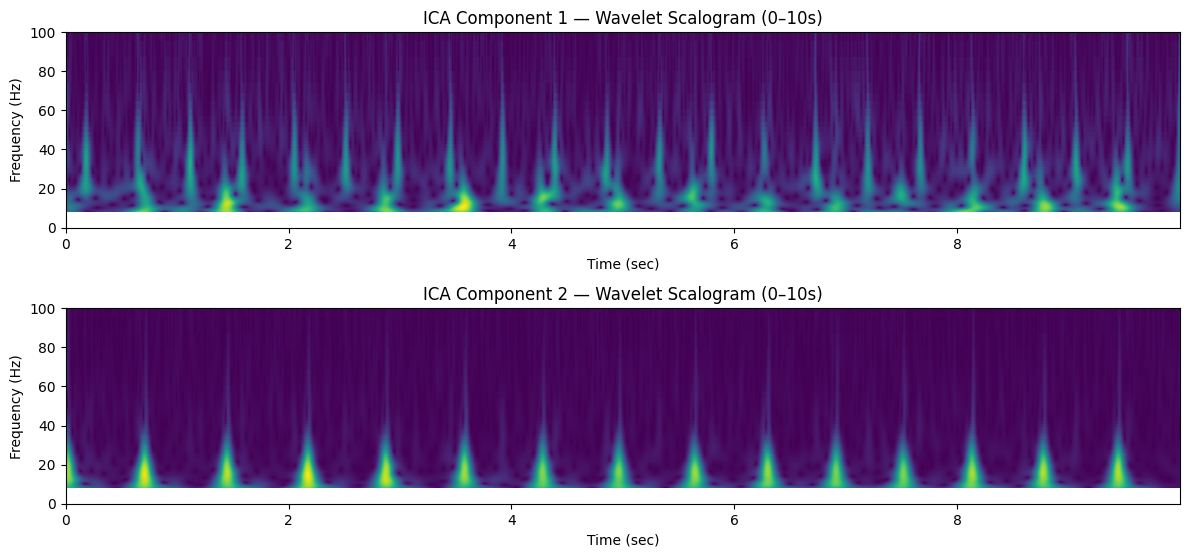

In [67]:
end_idx = int(10 * fs)
time_limit = time[:end_idx]
time = np.arange(ica_components.shape[1]) / fs

wavelet = 'cmor1.5-1.0'         # complex Morlet
scales = np.arange(1, 128)      # max scale for resolution

plt.figure(figsize=(12, 8))
for i in range(ica_components.shape[0]):
    sig10 = ica_components[i, :end_idx]
    coeffs, freqs = pywt.cwt(sig10, scales, wavelet, sampling_period=1/fs)

    plt.subplot(3, 1, i+1)
    plt.pcolormesh(time_limit, freqs, np.abs(coeffs), shading='auto')
    plt.title(f'ICA Component {i+1} — Wavelet Scalogram (0–10s)')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (sec)')
    plt.ylim(0, 100)

plt.tight_layout()
plt.show()

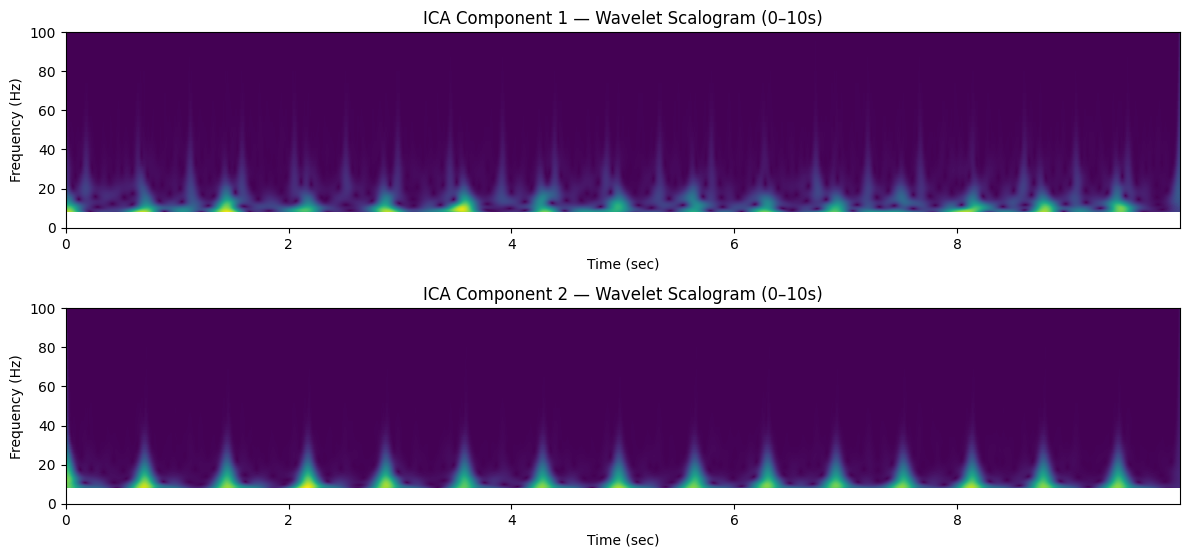

In [68]:
plt.figure(figsize=(12, 8))
for i in range(filtered_signals.shape[0]):
    sig10 = filtered_signals[i, :end_idx]
    coeffs, freqs = pywt.cwt(sig10, scales, wavelet, sampling_period=1/fs)

    plt.subplot(3, 1, i+1)
    plt.pcolormesh(time_limit, freqs, np.abs(coeffs), shading='auto')
    plt.title(f'ICA Component {i+1} — Wavelet Scalogram (0–10s)')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (sec)')
    plt.ylim(0, 100)

plt.tight_layout()
plt.show()